In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tpm = pd.read_csv("../../data/supp12.tsv", sep="\t", header=0, index_col=list(range(3)), usecols=list(range(5)))
tpm.head()

Mouse_gene_TPM  Human_gene_TPM
Subclass Gene   Transcript                                        
Astro    TSPAN6 ENST00000373020.8            45.27           86.94
         DPM1   ENST00000371582.8           213.19           88.54
                ENST00000371588.9           213.19           88.54
         FUCA2  ENST00000002165.10          142.11           26.09
         GCLC   ENST00000509541.5            28.15           36.55

In [3]:
# just get the first transcript in each gene
tpm = tpm.groupby(['Subclass', 'Gene']).first()
tpm.head()

Mouse_gene_TPM  Human_gene_TPM
Subclass Gene                                  
Astro    AAAS             16.24          121.01
         AACS             36.53           19.05
         AAMDC            40.93           50.30
         AAMP             40.81           26.85
         AARSD1           37.88           56.02

In [4]:
# rename the columns
tpm.columns = ['mouse', 'human']
tpm.head()

mouse   human
Subclass Gene                 
Astro    AAAS    16.24  121.01
         AACS    36.53   19.05
         AAMDC   40.93   50.30
         AAMP    40.81   26.85
         AARSD1  37.88   56.02

In [5]:
clusters = np.unique([i[0] for i in tpm.index])

In [6]:
mouse_genes = [tpm['mouse'].T[cluster] for cluster in clusters]

In [7]:
pd.concat(mouse_genes, axis=1)

,mouse,mouse,mouse,mouse,mouse,mouse,mouse,mouse,mouse,mouse,mouse,mouse,mouse,mouse,mouse
Gene,,,,,,,,,,,,,,,
AAAS,16.24,19.78,42.54,29.22,35.00,39.92,31.53,33.07,44.97,NaN,55.73,27.03,42.87,22.82,24.11
AACS,36.53,46.98,65.38,65.94,48.07,39.30,51.58,56.30,47.17,NaN,NaN,27.79,NaN,41.09,NaN
AAMDC,40.93,NaN,65.52,NaN,30.99,NaN,32.27,34.22,53.17,NaN,154.04,72.06,28.05,40.45,36.48
AAMP,40.81,125.77,192.35,150.80,145.13,170.92,167.82,195.91,213.13,238.55,130.57,250.83,256.75,195.22,269.62
AARSD1,37.88,121.90,147.34,75.35,127.79,136.71,111.07,126.37,141.80,287.84,38.70,132.82,142.82,147.45,176.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UBQLN4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.65
UBTF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.15
XXYLT1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.27


In [8]:
mouse_genes = pd.concat(mouse_genes, axis=1).dropna()

In [9]:
mouse_genes.columns = clusters

In [10]:
human_genes = pd.concat([tpm['human'].T[cluster] for cluster in clusters], axis=1).dropna()

In [11]:
human_genes.columns = clusters

# get correlation network

In [12]:
import igraph as ig
import leidenalg as la
from umap import UMAP

In [13]:
from scipy.stats import rankdata

In [14]:
from numpy import corrcoef

In [15]:
corr_human = corrcoef(human_genes.values, human_genes.values)[:human_genes.shape[0], :human_genes.shape[0]]

In [16]:
corr_mouse = corrcoef(mouse_genes.values, mouse_genes.values)[:human_genes.shape[0], :human_genes.shape[0]]

In [17]:
corr_human.shape

(1970, 1970)

In [18]:
def get_comparative_inds(corr_a, corr_b, n_idx = 30):
    """
    Identifies the top n indecies in a for each row in a, 
    as well as the ranks of the corresponding indexs for the same row in be b
    
    
    inputs:
        corr_a : a matrix of correlation coefficients
        corr_b : a different matrix of correlation coefficients
        n_idx : the number of indicies to check
    """
    
    top_n_a = np.argsort(corr_a)[:, -(n_idx+1):-1]
    idx_ranks_b = rankdata(corr_b, axis=0)
    idx_ranks_b = idx_ranks_b
#     ranks_in_b = [idx_ranks_b[i, top_n_a[i]][::-1] for i in range(len(corr_a))] 
    return idx_ranks_b, top_n_a

In [19]:
# top N co-expressed genes species a
# rank coexpression for species b
# get auroc of ranks, where true positives are top N in a

In [20]:
m_ranks, top_in_h = get_comparative_inds(corr_human, corr_mouse)

In [34]:
h_ranks, top_in_m = get_comparative_inds(corr_mouse, corr_human)

In [22]:
from sklearn.metrics import roc_auc_score

In [25]:
aucs_htom=[]
for i in range(m_ranks.shape[0]):
    labels = np.zeros(top_in_h.shape[0])
    labels[top_in_h[i]] = 1
    aucs_htom.append(roc_auc_score(y_true=labels, y_score=m_ranks[i]))

(array([ 1.,  1.,  1.,  1.,  1.,  2.,  1.,  3.,  2.,  4.,  3.,  0.,  8.,
         5.,  3.,  6.,  7., 10.,  7.,  9., 17.,  7., 15., 17., 18., 15.,
        26., 20., 25., 29., 26., 24., 34., 28., 30., 42., 30., 41., 48.,
        43., 36., 31., 46., 36., 35., 44., 40., 39., 56., 43., 41., 46.,
        36., 41., 37., 41., 37., 34., 33., 37., 43., 29., 37., 39., 41.,
        35., 22., 27., 21., 34., 18., 38., 25., 18., 21., 15., 10., 14.,
         8., 18.,  4.,  7.,  5.,  6.,  4.,  4.,  3.,  1.,  2.,  2.,  1.,
         6.,  2.,  6.,  2.,  1.,  1.,  0.,  0.,  1.]),
 array([0.2317354 , 0.23895266, 0.24616993, 0.2533872 , 0.26060447,
        0.26782174, 0.275039  , 0.28225627, 0.28947354, 0.29669081,
        0.30390808, 0.31112534, 0.31834261, 0.32555988, 0.33277715,
        0.33999442, 0.34721168, 0.35442895, 0.36164622, 0.36886349,
        0.37608076, 0.38329802, 0.39051529, 0.39773256, 0.40494983,
        0.4121671 , 0.41938436, 0.42660163, 0.4338189 , 0.44103617,
        0.44825344, 0.4554

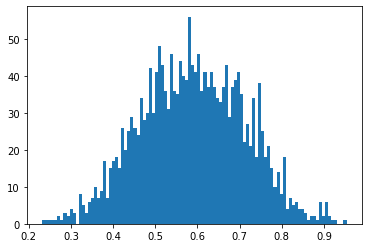

In [26]:
plt.hist(aucs_htom, bins=100)

In [37]:
aucs_mtoh=[]
for i in range(h_ranks.shape[0]):
    labels = np.zeros(top_in_m.shape[0])
    labels[top_in_h[i]] = 1
    aucs_mtoh.append(roc_auc_score(y_true=labels, y_score=h_ranks[i]))

(array([ 2.,  1.,  0.,  0.,  1.,  3.,  2.,  1.,  0.,  1.,  5.,  1.,  1.,
         0.,  3.,  3.,  2.,  3.,  1.,  2.,  2.,  3.,  3.,  0.,  2.,  3.,
         4.,  4.,  7.,  6.,  2.,  2.,  4.,  7., 10.,  2.,  9.,  8.,  9.,
         9.,  9., 11.,  7., 14., 12.,  9.,  9., 14.,  9., 14.,  6.,  9.,
        16., 12.,  8.,  5., 15., 15., 12., 13., 11., 13., 11., 13., 13.,
        30., 17., 13., 19., 15., 16., 19., 22., 32., 19., 40., 29., 47.,
        41., 56., 61., 64., 57., 56., 43., 75., 60., 84., 62., 74., 93.,
        82., 61., 71., 68., 57., 35., 28., 12.,  4.]),
 array([0.9539433 , 0.95439304, 0.95484278, 0.95529253, 0.95574227,
        0.95619201, 0.95664175, 0.95709149, 0.95754124, 0.95799098,
        0.95844072, 0.95889046, 0.95934021, 0.95978995, 0.96023969,
        0.96068943, 0.96113918, 0.96158892, 0.96203866, 0.9624884 ,
        0.96293814, 0.96338789, 0.96383763, 0.96428737, 0.96473711,
        0.96518686, 0.9656366 , 0.96608634, 0.96653608, 0.96698582,
        0.96743557, 0.9678

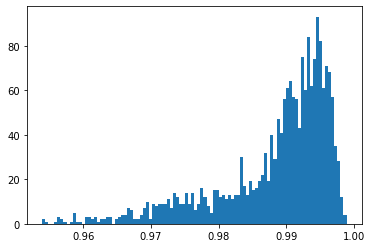

In [38]:
plt.hist(aucs_mtoh, bins=100)

In [44]:
gene_aucs = pd.DataFrame(index=mouse_genes.index, columns=['mouse_auc', 'human_auc'], data=np.array([aucs_mtoh, aucs_htom]).T)

In [45]:
gene_aucs

,mouse_auc,human_auc
Gene,,
AAMP,0.989751,0.609424
AARSD1,0.990790,0.579742
AASDHPPT,0.996057,0.392818
ABCC5,0.988007,0.429957
ABCE1,0.990318,0.587259
...,...,...
ZNF800,0.975069,0.542165
ZNF830,0.971323,0.528299
ZNHIT1,0.988428,0.326838


In [46]:
from scipy.stats import spearmanr
spearmanr(gene_aucs.mouse_auc.values, gene_aucs.human_auc.values)

SpearmanrResult(correlation=0.19005510408323945, pvalue=1.7720683259983714e-17)

In [28]:
?roc_auc_score

Signature:
roc_auc_score(
    y_true,
    y_score,
    *,
    average='macro',
    sample_weight=None,
    max_fpr=None,
    multi_class='raise',
    labels=None,
)
Docstring:
Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC)
from prediction scores.

Note: this implementation can be used with binary, multiclass and
multilabel classification, but some restrictions apply (see Parameters).

Read more in the :ref:`User Guide <roc_metrics>`.

Parameters
----------
y_true : array-like of shape (n_samples,) or (n_samples, n_classes)
    True labels or binary label indicators. The binary and multiclass cases
    expect labels with shape (n_samples,) while the multilabel case expects
    binary label indicators with shape (n_samples, n_classes).

y_score : array-like of shape (n_samples,) or (n_samples, n_classes)
    Target scores.

    * In the binary case, it corresponds to an array of shape
      `(n_samples,)`. Both probability estimates and non-thresholded
      dec